## PFI METHOD SHUFFLING FUTURE COVARIATES


In [ ]:
%tensorboard --logdir logs #Clik above this to open tensorboard!

In [211]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime, os

# Data preparation
df = pd.read_csv('synthetic_data_harvard_0.csv')
df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
df.set_index('timestamp', inplace=True)
df = df.drop('time_index', axis=1, errors='ignore'
target_variable = "V1"
covariate_variables = ['V2', 'V3', 'V4']

target = TimeSeries.from_series(df[target_variable].astype(np.float32))
covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

# Split into train and test sets
train_test_split = int(0.9 * len(target))
train_target, test_target = target[:train_test_split], target[train_test_split:]
train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

# Model definition
model = TFTModel(
    model_name="TFT_causal_discovery",
    input_chunk_length=30,
    output_chunk_length=14,
    hidden_size=64,
    lstm_layers=2,
    num_attention_heads=4,
    batch_size=32,
    n_epochs=30,
    add_relative_index=True,
    log_tensorboard=True,
)

# Train the model using both past and future covariates!
model.fit(train_target, past_covariates=train_covariates, future_covariates=train_covariates, verbose=True) 

# Predict using both past and future covariates
num_samples = 100
predictions = model.predict(n=len(test_target), series=train_target, past_covariates=covariates, future_covariates=covariates, num_samples=num_samples)
quantile_predictions = predictions.quantile_timeseries(0.5)
real_loss = mse(test_target, quantile_predictions)
print(f"Real loss: {real_loss}")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 14.3 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Epoch 29: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, v_num=logs, train_loss=0.767]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, v_num=logs, train_loss=0.767]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s]
Real loss: 0.32820294464428246


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s]
Real loss: 0.32762792515843586


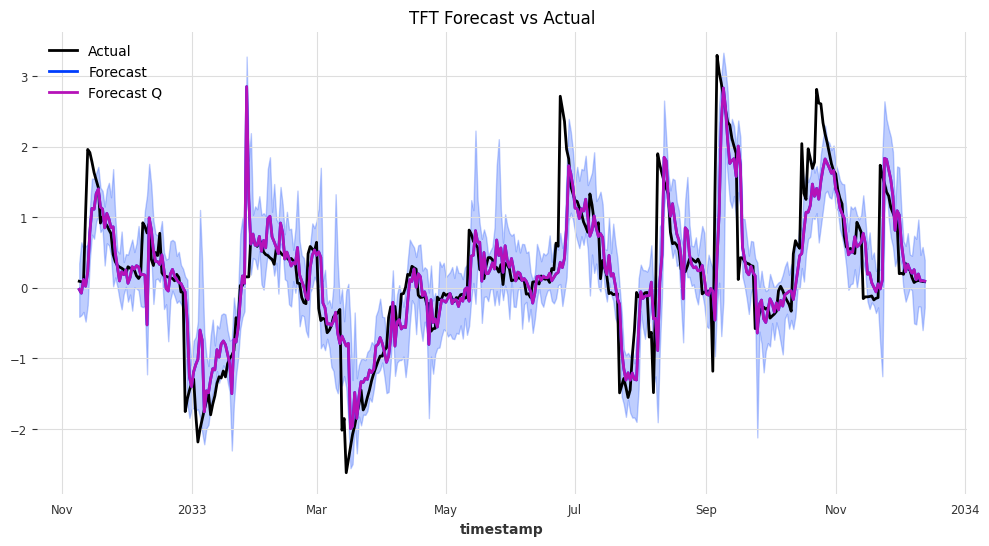

In [214]:
# Plotting
num_samples = 100
predictions = model.predict(n=len(test_target), series=train_target, past_covariates=covariates, future_covariates=covariates , num_samples=num_samples)
point_predictions = predictions.quantile_timeseries(0.5)

real_loss = mse(test_target, quantile_predictions)
print(f"Real loss: {real_loss}")

plt.figure(figsize=(12, 6))
test_target.plot(label="Actual")
predictions.plot(label="Forecast")
point_predictions.plot(label="Forecast (quantile 0.5)")
plt.title("TFT Forecast vs Actual")
plt.legend()
plt.show()

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.80it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



V2: shuffled_loss = 1.2543160684780446, pfi_ratio = 0.26120045289379995, real_loss = 0.32762792515843586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



V3: shuffled_loss = 0.6227546112222289, pfi_ratio = 0.526094739813211, real_loss = 0.32762792515843586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
V4: shuffled_loss = 0.5656660946249271, pfi_ratio = 0.5791896107467325, real_loss = 0.32762792515843586
Covariates likely to have causal relationships: ['V2', 'V3', 'V4']


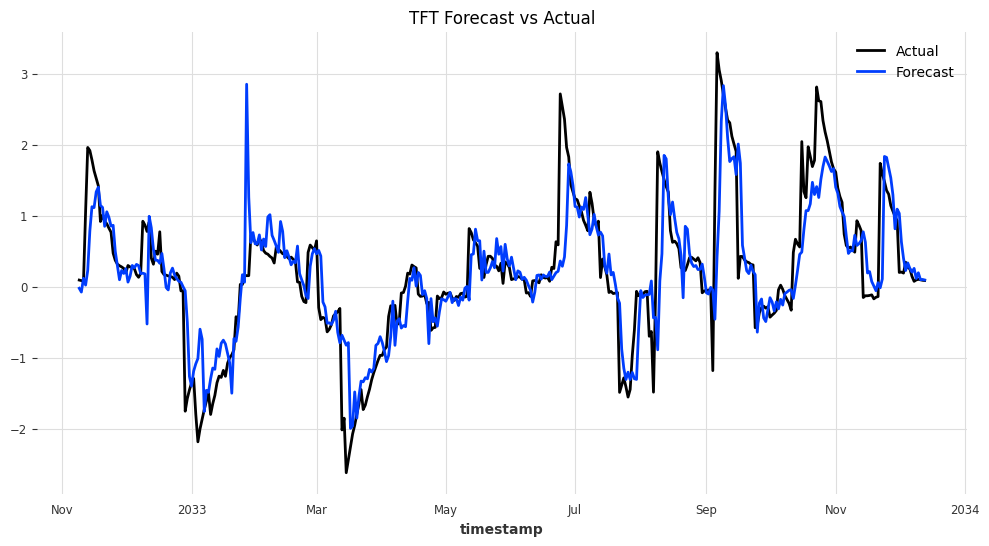

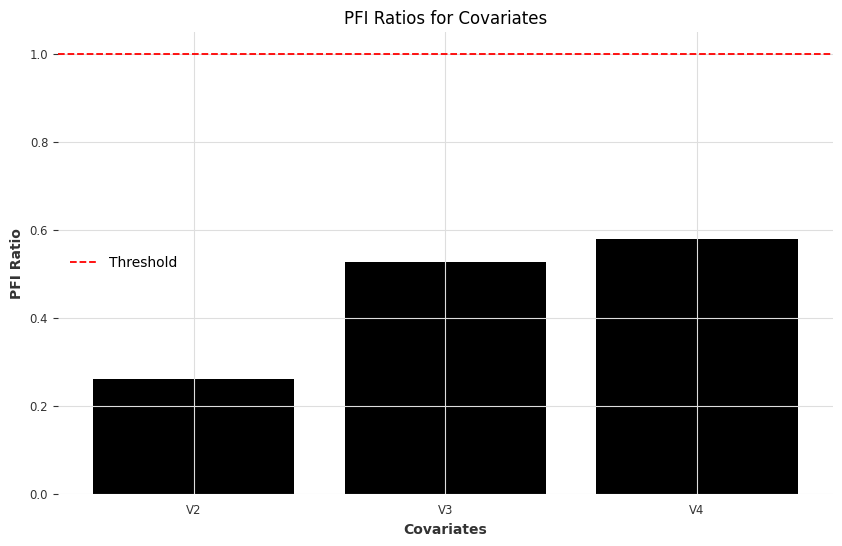

In [219]:

# Function to shuffle future covariates
def shuffle_future_covariate(covariates, column_name, train_length):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[train_length:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

# PFI method shuffling only future covariates
threshold = 1.0  # You can adjust this value
pfi_results = {}
num_samples = 10
for column in covariates.columns:
    # Shuffle only the future part of the current covariate
    shuffled_covariates = shuffle_future_covariate(covariates, column, train_test_split)
    
    # Make predictions using the shuffled future covariate
    # predictions = model.predict(n=len(test_target), series=train_target, 
    #                                      past_covariates=covariates, 
    #                                      future_covariates=shuffled_covariates, 
    #                                      )
    
    shuffled_predictions = model.predict(n=len(test_target), series=train_target, 
                                         past_covariates=covariates, 
                                         future_covariates=shuffled_covariates, 
                                         num_samples=num_samples)
    predictions = shuffled_predictions.quantile_timeseries(0.5)
    
    # Calculate the loss with shuffled future covariate
    shuffled_loss = mse(test_target, predictions)
    
    # Calculate the PFI ratio
    pfi_ratio = real_loss / shuffled_loss
    pfi_results[column] = shuffled_loss
    print(f"{column}: shuffled_loss = {shuffled_loss}, pfi_ratio = {pfi_ratio}, real_loss = {real_loss}")

# # Interpret PFI results
# causal_covariates = [col for col, ratio in pfi_results.items() if ratio < threshold]
# print(f"Covariates likely to have causal relationships: {causal_covariates}")



# Plot PFI ratios
plt.figure(figsize=(10, 6))
plt.bar(pfi_results.keys(), pfi_results.values())
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("PFI Ratios for Covariates")
plt.xlabel("Covariates")
plt.ylabel("PFI Ratio")
plt.legend()
plt.show()

In [220]:
import json
import math


results = [
    {
        'target': 'var1',
        'realloss': 0.32762792515843586,
        'shuffleloss': {
            'var1': math.nan, #NOT TESTED
            'var2': 2.279167916490581,  # Strong influence on var2
            'var3': 0.6227546112222289,  # Strong influence on var3
            'var4': 0.5708211872257679   # No direct influence
        }
    },

    {
        'target': 'var2',
        'realloss': 0.6069193357112086,
        'shuffleloss': {
            'var1': 1.0305384359828513,  # Influenced by var1
            'var2': math.nan, #NOT TESTED
            'var3': 0.6099983868622401,
            'var4': 0.7283130425315173   # Influence on var4
        }
    },
    {
        'target': 'var3',
        'realloss': 0.18816787329387705,
        'shuffleloss': {
            'var1': 0.6226088593502809,  # Influenced by var1
            'var2': 0.2021811139374467,
            'var3': math.nan, #NOT TESTED
            'var4': 0.20130413271558134,   # Influence on var4
        }
    },
    {
        'target': 'var4',
        'realloss': 0.16726788038442675,
        'shuffleloss': {
            'var1': 0.22241675853729248,
            'var2': 0.22357077896595,  # Influenced by var2
            'var3': 0.21973754465579987,  # Influenced by var3
            'var4': math.nan #0.0001 #NOT TESTED
        }
    }
]

# Save this to a file
with open('./PFI_results/dataset_0_shuffeled_future_covariates.json'', 'w') as f:
    json.dump(results, f, indent=2)

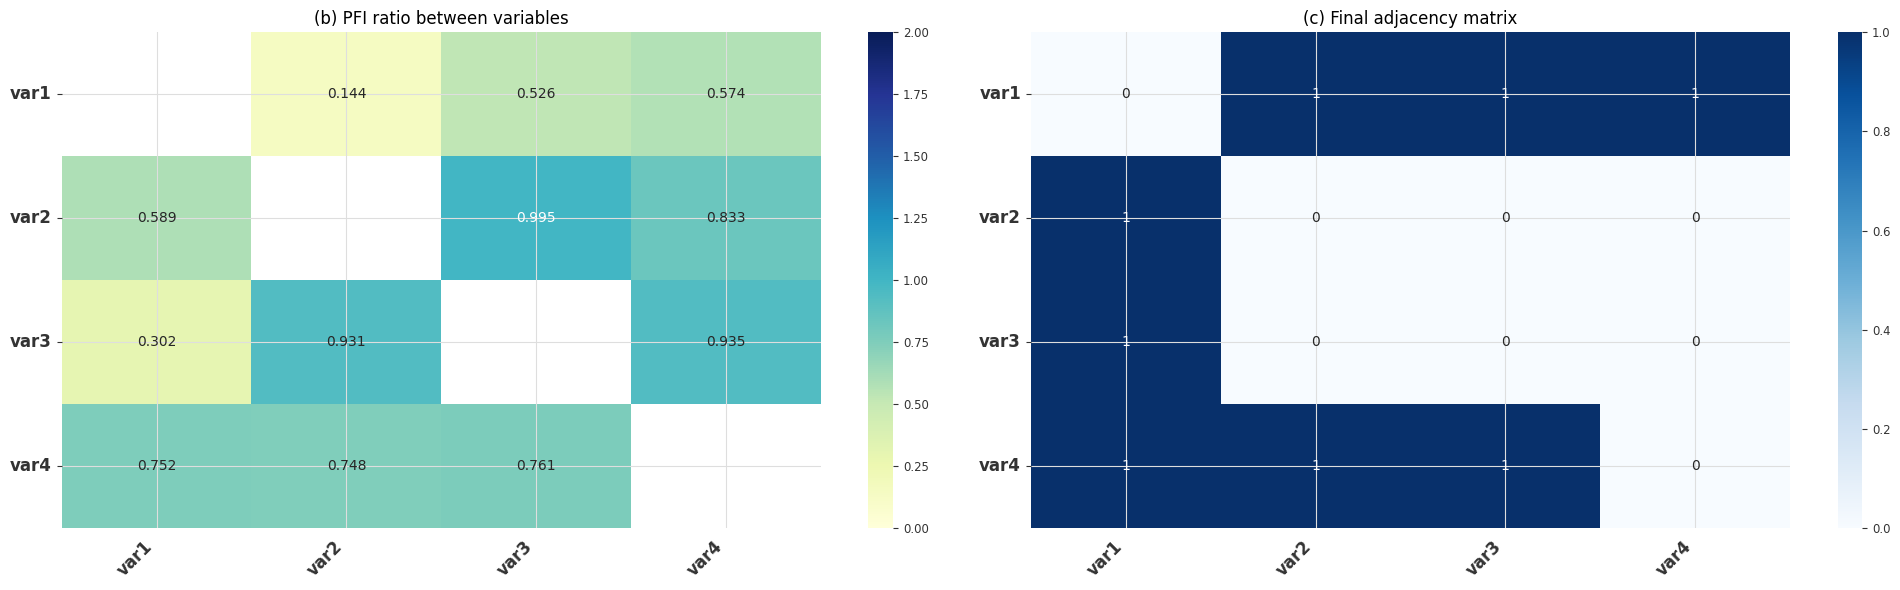

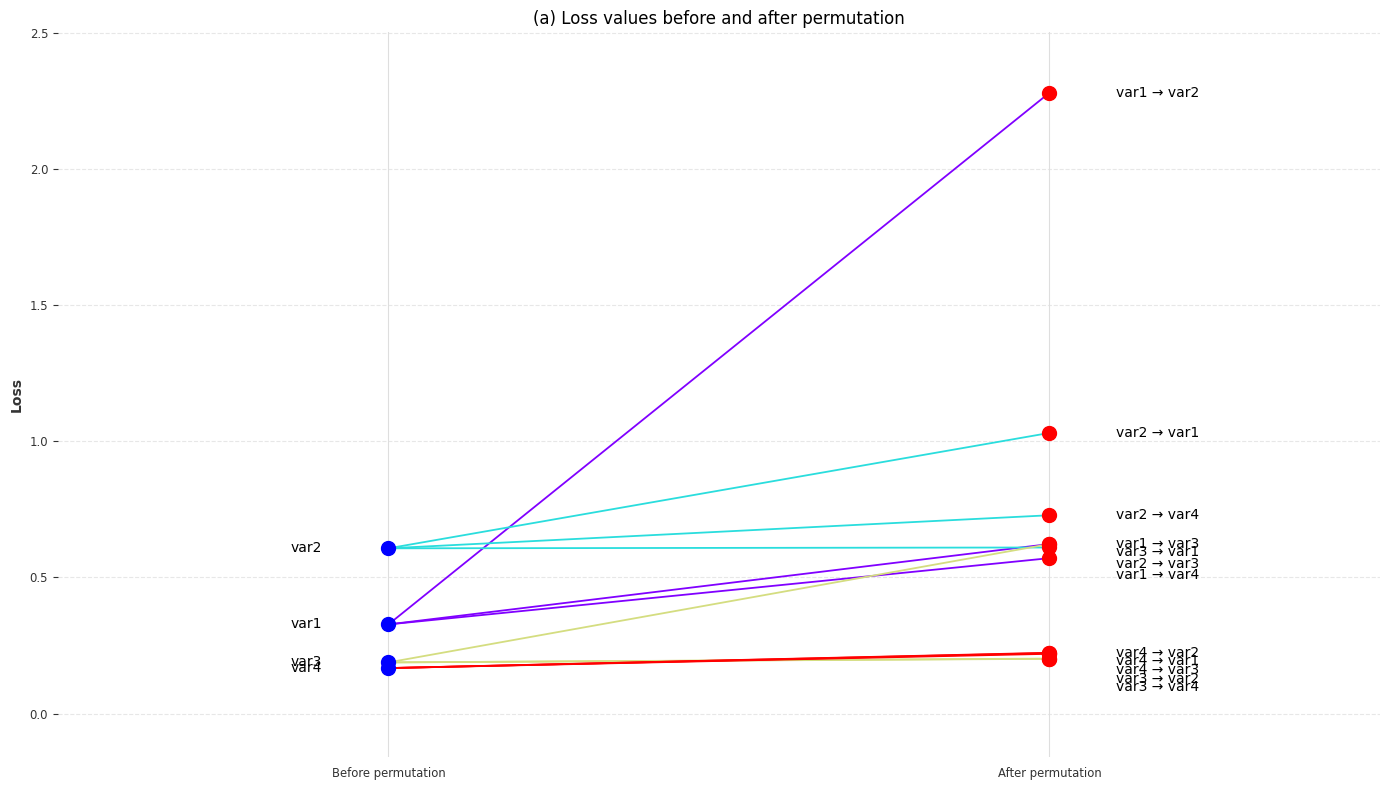

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

# Load results from the file
with open('./PFI_results/dataset_0_shuffeled_future_covariates.json.json', 'r') as f:
    results = json.load(f)

variables = [result['target'] for result in results]
n_vars = len(variables)


# Prepare data for visualization
losses_before = np.array([result['realloss'] for result in results])
losses_after = np.array([[result['shuffleloss'][var] for var in variables] for result in results])
pfi_ratios = losses_before[:, np.newaxis] / losses_after

# Create visualizations
fig, ( ax2, ax3) = plt.subplots(1, 2, figsize=(20, 6))

# (b) The PFI ratio between every two variables
sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax2, vmin=0, vmax=2)
ax2.set_xticklabels(variables, rotation=45, ha='right',fontsize=12, fontweight='bold')
ax2.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
ax2.set_title('(b) PFI ratio between variables')

# (c) The final adjacency matrix
threshold = 0.8  # Adjust as needed
adjacency_matrix = (pfi_ratios < threshold).astype(int)
sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_xticklabels(variables, rotation=45, ha='right',fontsize=12, fontweight='bold')
ax3.set_yticklabels(variables, rotation=0,fontsize=12, fontweight='bold')
ax3.set_title('(c) Final adjacency matrix')

plt.tight_layout()
plt.show()



colors = plt.cm.rainbow(np.linspace(0, 1, n_vars))

plt.figure(figsize=(14, 8))  # Increased figure width for better label placement

# Dictionary to store y-positions of labels
label_positions = {}

for i, result in enumerate(results):
    target = result['target']
    realloss = result['realloss']
    color = colors[i]
    
    # Plot a line for each variable being permuted, excluding NaN values
    for var, shuffleloss in result['shuffleloss'].items():
        if not math.isnan(shuffleloss):
            plt.plot([1, 2], [realloss, shuffleloss], '-', color=color,
                     label=f'{target} (permute {var})' if var == target else "")
            
            # Store the y-position for the label
            if shuffleloss in label_positions:
                label_positions[shuffleloss].append(f"{target} → {var}")
            else:
                label_positions[shuffleloss] = [f"{target} → {var}"]

    # Plot points
    plt.scatter([1], [realloss], color='blue', s=100, zorder=5)
    valid_shuffleloss = [loss for loss in result['shuffleloss'].values() if not math.isnan(loss)]
    plt.scatter([2] * len(valid_shuffleloss), valid_shuffleloss,
                color='red', s=100, zorder=5)

    # Add variable labels on the left side
    plt.text(0.9, realloss, target, ha='right', va='center')

# Sort the label positions
sorted_positions = sorted(label_positions.items(), reverse=True)

# Function to check if two labels overlap
def labels_overlap(y1, y2, height):
    return abs(y1 - y2) < height

# Add labels on the right side with adjusted positions
label_height = 0.03  # Increased label height for better separation
placed_labels = []

for y_pos, labels in sorted_positions:
    for label in labels:
        adjusted_y = y_pos
        while any(labels_overlap(adjusted_y, pl[0], label_height) for pl in placed_labels):
            adjusted_y -= label_height / 2
        placed_labels.append((adjusted_y, label))

# Sort placed labels by their adjusted y-position
placed_labels.sort(reverse=True)

# Plot the labels
for adjusted_y, label in placed_labels:
    plt.text(2.1, adjusted_y, label, ha='left', va='center')

# Customize the plot
plt.xlim(0.5, 2.5)
max_loss = max(max(max(loss for loss in result['shuffleloss'].values() if not math.isnan(loss)), result['realloss']) for result in results)
y_margin = 0.1 * (max_loss - plt.ylim()[0])  # 10% margin
plt.ylim(plt.ylim()[0] - y_margin, max_loss + y_margin)
plt.xticks([1, 2], ['Before permutation', 'After permutation'])
plt.ylabel('Loss')
plt.title('(a) Loss values before and after permutation')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [138]:
shuffled_covariates

<TimeSeries (DataArray) (timestamp: 4000, component: 3, sample: 1)> Size: 48kB
array([[[ 0.18871282],
        [-0.70036834],
        [ 0.01331522]],

       [[ 0.24049647],
        [ 0.7070942 ],
        [-1.2322568 ]],

       [[-0.9952517 ],
        [-0.76857126],
        [-0.5572574 ]],

       ...,

       [[ 0.09675793],
        [-0.31029373],
        [-0.0963321 ]],

       [[ 0.09036161],
        [ 0.17689268],
        [-1.2445447 ]],

       [[ 0.08715896],
        [-0.2223165 ],
        [-0.1057583 ]]], dtype=float32)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 32kB 2023-01-01 ... 2033-12-13
  * component  (component) object 24B 'V1' 'V2' 'V3'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [139]:
covariates

<TimeSeries (DataArray) (timestamp: 4000, component: 3, sample: 1)> Size: 48kB
array([[[ 0.18871282],
        [-0.70036834],
        [-3.6660945 ]],

       [[ 0.24049647],
        [ 0.7070942 ],
        [-1.0745621 ]],

       [[-0.9952517 ],
        [-0.76857126],
        [-0.37744227]],

       ...,

       [[ 0.09675793],
        [-0.31029373],
        [ 0.45811683]],

       [[ 0.09036161],
        [ 0.17689268],
        [ 0.03603492]],

       [[ 0.08715896],
        [-0.2223165 ],
        [-0.05555054]]], dtype=float32)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 32kB 2023-01-01 ... 2033-12-13
  * component  (component) object 24B 'V1' 'V2' 'V3'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



V1: shuffled_loss = 1.172417005495787, pfi_ratio = 0.5176650738314368, real_loss = 0.6069193357112086
V1 is validated as a causal variable.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



V3: shuffled_loss = 0.6385818651728505, pfi_ratio = 0.9504174308910706, real_loss = 0.6069193357112086
V3 is validated as a causal variable.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
V4: shuffled_loss = 0.6342433017482696, pfi_ratio = 0.9569187944724943, real_loss = 0.6069193357112086
V4 is validated as a causal variable.
Validated covariates: ['V1', 'V3', 'V4']
PFI Results: {'V1': 0.5176650738314368, 'V3': 0.9504174308910706, 'V4': 0.9569187944724943}


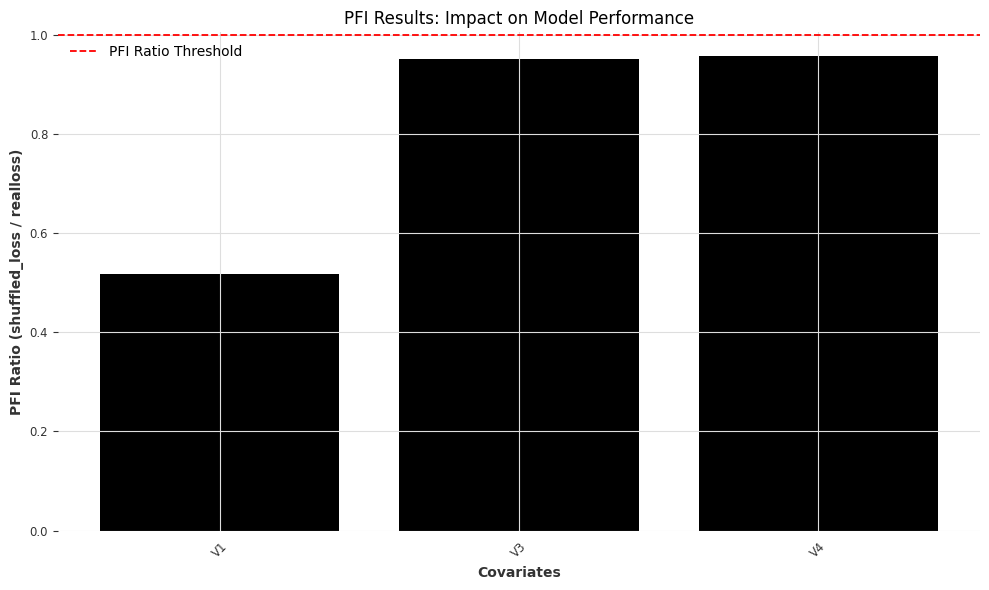

In [210]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime, os

# TESTING IF SHUFFLING PAST AND FUTURE COVARAITES WORKS

# Function to shuffle a specific column in the covariates
def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

# Calculate the real loss


# PFI
threshold = 1.0  # You can adjust this value
validated_covariates = list(covariates.columns)
pfi_results = {}

for column in covariates.columns:
    # Shuffle the current covariate
    shuffled_covariates = shuffle_covariate(covariates, column)
    
    # Make predictions using the shuffled covariate
    #shuffled_predictions = model.predict(n=len(test_target), series=train_target, past_covariates=shuffled_covariates)
    shuffled_predictions = model.predict(n=len(test_target), series=train_target, 
                                         past_covariates=shuffled_covariates, 
                                         future_covariates=shuffled_covariates, 
                                         num_samples=num_samples)
    predictions = shuffled_predictions.quantile_timeseries(0.5)
    # Calculate the loss with shuffled covariate
    shuffled_loss = mse(test_target, shuffled_predictions)
    
    # Calculate the PFI ratio
    pfi_ratio = real_loss / shuffled_loss
        
    print(f"{column}: shuffled_loss = {shuffled_loss}, pfi_ratio = {pfi_ratio}, real_loss = {real_loss}")

    
    # Check if the variable is causal
    if pfi_ratio <= threshold:
        print(f"{column} is validated as a causal variable.")
    else:
        validated_covariates.remove(column)
        print(f"Removed {column} as it didn't significantly impact the predictions.")
    
    pfi_results[column] = pfi_ratio

print("Validated covariates:", validated_covariates)
print("PFI Results:", pfi_results)

# Plot PFI results
plt.figure(figsize=(10, 6))
plt.bar(pfi_results.keys(), pfi_results.values())
plt.title("PFI Results: Impact on Model Performance")
plt.xlabel("Covariates")
plt.ylabel("PFI Ratio (shuffled_loss / realloss)")
plt.xticks(rotation=45)
plt.axhline(y=threshold, color='r', linestyle='--', label='PFI Ratio Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [159]:
train_target

<TimeSeries (DataArray) (timestamp: 3600, component: 1, sample: 1)> Size: 14kB
array([[[0.22628361]],

       [[1.7868549 ]],

       [[0.3644592 ]],

       ...,

       [[0.3094669 ]],

       [[0.2867913 ]],

       [[0.137276  ]]], dtype=float32)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 29kB 2023-01-01 ... 2032-11-08
  * component  (component) object 8B 'V4'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [160]:
from darts.explainability import TFTExplainer

# Create the explainer
explainer = TFTExplainer(model)

# Get the last point of your training data
last_train_point = train_target.time_index[-1]

# Create a short series for explanation
short_series = train_target
short_covariates = train_covariates

# Explain for a shorter horizon (e.g., 7 days instead of 14)
explainability_result = explainer.explain(series=short_series, past_covariates=short_covariates, future_covariates=short_covariates, n=7)

# Now you can analyze the explainability results
print(explainer.get_encoder_importance())
print(explainer.get_decoder_importance())
print(explainer.get_static_covariates_importance())

# Plot attention weights
explainer.plot_attention(explainability_result)

# Plot variable importance
explainer.plot_variable_selection(explainability_result)

TypeError: TFTExplainer.explain() got an unexpected keyword argument 'series'

In [207]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(model)

explainability_result = explainer.explain()

ValueError: For the given forecasting horizon `n=14`, the provided future covariates at dataset index `0` do not extend far enough into the future. As `n <= output_chunk_length` the future covariates must end at time step `2032-11-22 00:00:00`, whereas now they end at time step `2032-11-08 00:00:00`.


ValueError: For the given forecasting horizon `n=14`, the provided future covariates at dataset index `0` do not extend far enough into the future. As `n <= output_chunk_length` the future covariates must end at time step `2032-11-22 00:00:00`, whereas now they end at time step `2032-11-08 00:00:00`.

In [ ]:
# import json
# #FAKE DATA!!!
# # Example results data reflecting the causal structure
# results = [
#     {
#         'target': 'var1',
#         'realloss': 0.2,
#         'shuffleloss': {
#             'var1': 0.25,
#             'var2': 0.2,  # Strong influence on var2
#             'var3': 0.2,  # Strong influence on var3
#             'var4': 0.3   # No direct influence
#         }
#     },
#     {
#         'target': 'var2',
#         'realloss': 0.4,
#         'shuffleloss': {
#             'var1': 1.1,  # Influenced by var1
#             'var2': 0.5,
#             'var3': 0.4,
#             'var4': 0.3   # Influence on var4
#         }
#     },
#     {
#         'target': 'var3',
#         'realloss': 0.3,
#         'shuffleloss': {
#             'var1': 0.9,  # Influenced by var1
#             'var2': 0.1,
#             'var3': 0.5,
#             'var4': 0.15   # Influence on var4
#         }
#     },
#     {
#         'target': 'var4',
#         'realloss': 0.5,
#         'shuffleloss': {
#             'var1': 0.6,
#             'var2': 1.5,  # Influenced by var2
#             'var3': 1.6,  # Influenced by var3
#             'var4': 0.7
#         }
#     }
# ]

# # Save this to a file
# with open('pfi_results.json', 'w') as f:
#     json.dump(results, f, indent=2)